In [3]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.1 MB/s eta 0:00:00


In [4]:
!pip install arrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.7 MB/s eta 0:00:00


In [1]:
import pandas as pd
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import remove_stopwords, strip_multiple_whitespaces, strip_numeric, strip_punctuation, strip_short, strip_tags
from gensim.corpora import Dictionary
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from umap import UMAP
from arrow import now
import arrow
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_val_score

# Data

In [2]:
twitter = pd.read_csv("/content/drive/MyDrive/ColabData/Twitter_ Non-Advert-Tabelle 1.csv", sep=';', usecols=['text', 'label'])
reddit = pd.read_csv("/content/drive/MyDrive/ColabData/Reddit_Combi.csv", sep=';', usecols=['body', 'label'])
reddit.rename(columns={'body': 'text'}, inplace=True)
df = pd.concat([twitter, reddit], ignore_index=True)

In [3]:
df

,text,label
0,speak-no-evil monkey Can I Be Honest With You...,1
1,Frau Goebbels early signs of psychosis psychot...,1
2,A lot of work and unfulfilled tasks plunge you...,1
3,Private health insurance delivers value for yo...,1
4,XpertOnline offers you the convenience of view...,1
...,...,...
5169,"Hi all, my mom has been working from home sinc...",1
5170,"I really think I lost my mind last night, I’d ...",1
5171,I feel like I died a long time ago and I just ...,1
5172,16f ... cant manage to make friends and get ov...,1


In [4]:
df.isnull().sum()

text     10
label     0
dtype: int64

In [5]:
df = df.dropna()

In [6]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
from plotly import express
express.pie(data_frame=df, names='label', color='label')

# Doc2Vec Model Training and Dimensionality Reduction with UMAP

In [10]:
# Preprocessing function
CUSTOM_FILTERS = [lambda x: x.lower(),
                  remove_stopwords,
                  strip_multiple_whitespaces,
                  strip_numeric,
                  strip_punctuation,
                  strip_short,
                  strip_tags]

# Preprocess text
df['text'] = df['text'].astype(str)
documents = df['text'].values.tolist()
texts = [preprocess_string(s=document, filters=CUSTOM_FILTERS) for document in documents]

# Create dictionary
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, min_count=20, epochs=40)
corpus_iterable = [TaggedDocument(item, [index]) for index, item in enumerate(corpus)]
doc2vec_model.build_vocab(corpus_iterable=corpus_iterable)
doc2vec_model.train(corpus_iterable=corpus_iterable, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
df['vectors'] = doc2vec_model.dv.vectors.tolist()

<ipython-input-10-3729b8b55f76>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-10-3729b8b55f76>:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
# Convert 'vectors' column to numpy array
vectors_array = np.array(df['vectors'].tolist())

# Dimensionality Reduction with UMAP
umap_model = UMAP(n_components=2, random_state=2024, verbose=1)
umap_result = umap_model.fit_transform(vectors_array)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP(n_jobs=1, random_state=2024, verbose=1)
Mon Apr 29 13:59:25 2024 Construct fuzzy simplicial set
Mon Apr 29 13:59:25 2024 Finding Nearest Neighbors
Mon Apr 29 13:59:25 2024 Building RP forest with 9 trees
Mon Apr 29 13:59:25 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	Stopping threshold met -- exiting after 4 iterations
Mon Apr 29 13:59:26 2024 Finished Nearest Neighbor Search
Mon Apr 29 13:59:26 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Apr 29 13:59:38 2024 Finished embedding


In [12]:
# Plot before balancing
express.scatter(x=umap_result[:,0], y=umap_result[:,1], color=df['label'])

In [ ]:
from plotly import express
express.pie(data_frame=df, names='label', color='label')

In [13]:
# Balance the classes (example using RandomOverSampler)
oversampler = RandomOverSampler(random_state=2024)
X_resampled, y_resampled = oversampler.fit_resample(vectors_array, df['label'])

In [15]:
# Plot after balancing
umap_result_resampled = umap_model.transform(X_resampled)

Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [16]:
express.scatter(x=umap_result_resampled[:,0], y=umap_result_resampled[:,1], color=y_resampled)

The text data is preprocessed using a set of custom filters, including converting text to lowercase, removing stopwords, stripping whitespace, digits, punctuation, short words, and HTML tags. After preprocessing, the text documents are converted into numerical vectors using Doc2Vec.

A dictionary of unique tokens, document vectors generated by the Doc2Vec model, and reduced-dimensional representations of the vectors using UMAP.

# Model Training and Evaluation

In [22]:
# Convert 'vectors' column to numpy array
vectors_array = np.array(df['vectors'].tolist())

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(vectors_array, df['label'], test_size=0.25, random_state=2024, stratify=df['label'])

In [23]:
# Train logistic regression model
fit_time_start = arrow.now()
regression = LogisticRegression(max_iter=100000, tol=1e-12).fit(X=X_train, y=y_train)
fit_time_end = arrow.now()
print('Model fit in {} iterations took {}'.format(regression.n_iter_[0], fit_time_end - fit_time_start))

# Evaluate model
prediction_time_start = arrow.now()
accuracy = accuracy_score(y_true=y_test, y_pred=regression.predict(X=X_test))
prediction_time_end = arrow.now()
print('Accuracy: {:5.4f}'.format(accuracy))
print('Model done in {}'.format(prediction_time_end - fit_time_start))

# Classification report
print(classification_report(y_true=y_test, y_pred=regression.predict(X=X_test)))

Model fit in 71 iterations took 0:00:00.244405
Accuracy: 0.8064
Model done in 0:00:00.253101
              precision    recall  f1-score   support

           0       0.67      0.28      0.39       290
           1       0.82      0.96      0.88      1001

    accuracy                           0.81      1291
   macro avg       0.74      0.62      0.64      1291
weighted avg       0.79      0.81      0.77      1291



Confusion Matrix (Logistic Regression):
 [[ 80 210]
 [ 40 961]]
Accuracy (Logistic Regression): 0.8063516653756778


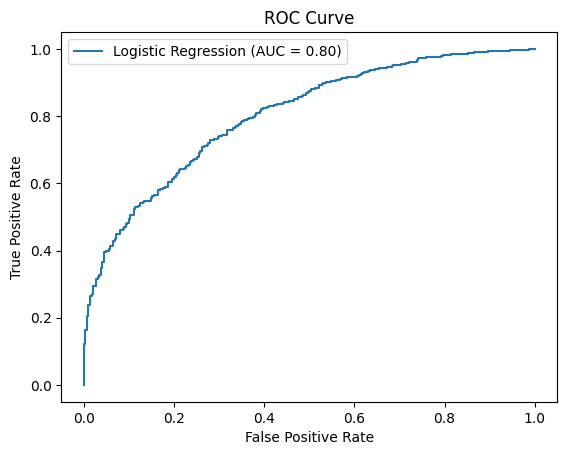

In [24]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Predictions for logistic regression model
y_pred_lr = regression.predict(X_test)
y_pred_proba_lr = regression.predict_proba(X_test)[:, 1]

# Confusion matrix for logistic regression model
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix (Logistic Regression):\n", conf_matrix_lr)

# Accuracy for logistic regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy (Logistic Regression):", accuracy_lr)

# ROC curve for logistic regression model
plot_roc_curve(y_test, y_pred_proba_lr, label='Logistic Regression')

# Hyperparameter Tuning with GridSearchCV

In [20]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters grid for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=100000, solver='lbfgs', tol=1e-12), param_grid, cv=5)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 100, 'penalty': 'l2'}


# Model Refinement and Evaluation

In [21]:
# Initialize Logistic Regression with best parameters
best_log_reg = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], max_iter=100000, solver='lbfgs', tol=1e-12)

# Train the model
best_log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_best = best_log_reg.predict(X_test)

# Evaluate accuracy
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

Accuracy: 0.8063516653756778
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.37      0.47       290
           1       0.84      0.94      0.89      1001

    accuracy                           0.81      1291
   macro avg       0.74      0.65      0.68      1291
weighted avg       0.79      0.81      0.79      1291



Confusion Matrix (Logistic Regression after Hyperparameter Tuning with GridSearchCV):
 [[106 184]
 [ 57 944]]
Accuracy (Logistic Regression after Hyperparameter Tuning with GridSearchCV): 0.8133230054221534


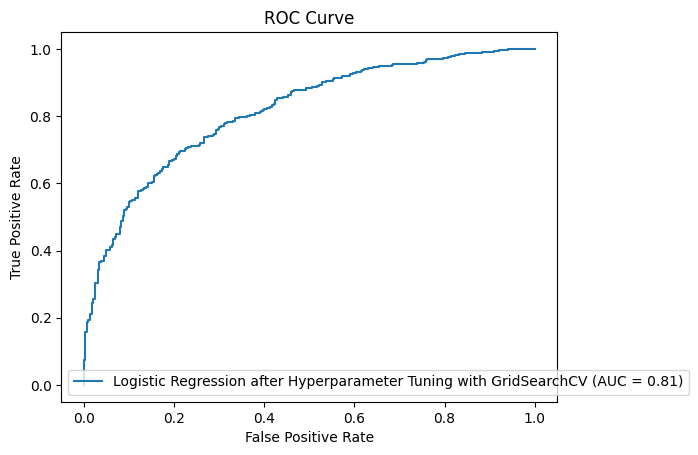

In [25]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Predictions for logistic regression model
y_pred_lr = best_log_reg.predict(X_test)
y_pred_proba_lr = best_log_reg.predict_proba(X_test)[:, 1]

# Confusion matrix for logistic regression model
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix (Logistic Regression after Hyperparameter Tuning with GridSearchCV):\n", conf_matrix_lr)

# Accuracy for logistic regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy (Logistic Regression after Hyperparameter Tuning with GridSearchCV):", accuracy_lr)

# ROC curve for logistic regression model
plot_roc_curve(y_test, y_pred_proba_lr, label='Logistic Regression after Hyperparameter Tuning with GridSearchCV')

# Cross-Validation

In [32]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with logistic regression
cv_scores = cross_val_score(LogisticRegression(max_iter=100000, solver='lbfgs', tol=1e-12), X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)

Cross-Validation Scores: [0.82064516 0.79354839 0.82193548 0.80232558 0.81136951]
